In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import make_column_transformer

GET THE DATA: 
- Import the data and add header columns
- Split dataset into Train and Test

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
r = requests.get(url)
r.headers

{'Date': 'Thu, 23 Jun 2022 01:07:54 GMT', 'Server': 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips SVN/1.7.14 Phusion_Passenger/4.0.53 mod_perl/2.0.11 Perl/v5.16.3', 'Last-Modified': 'Sat, 10 Aug 1996 18:14:48 GMT', 'ETag': '"3ca4a1-2fbb419259600"', 'Accept-Ranges': 'bytes', 'Content-Length': '3974305', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Content-Type': 'application/x-httpd-php'}

In [3]:
df_salary = pd.read_csv(url, header=None)
df_salary.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
df_salary.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


EXPLORING THE DATA:
- Identify Target Features
- Data Visualization

<AxesSubplot:xlabel='salary', ylabel='count'>

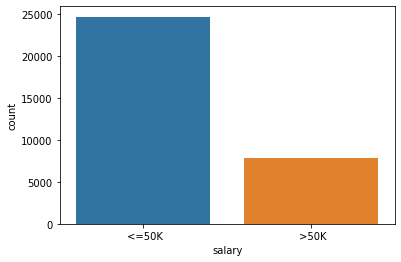

In [4]:
sns.countplot(x='salary', data=df_salary)

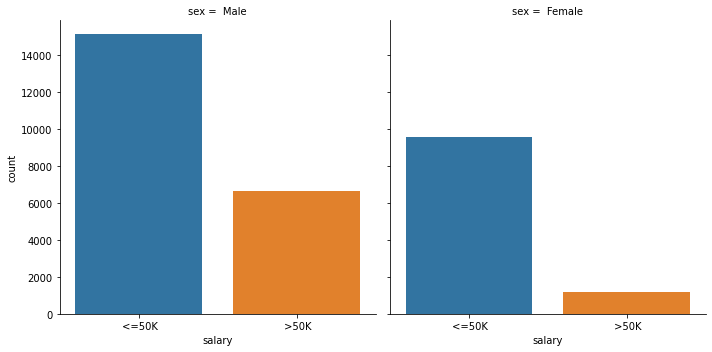

In [5]:
sns.catplot(x='salary', col='sex', kind='count', data=df_salary)

In [6]:
df_salary['education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

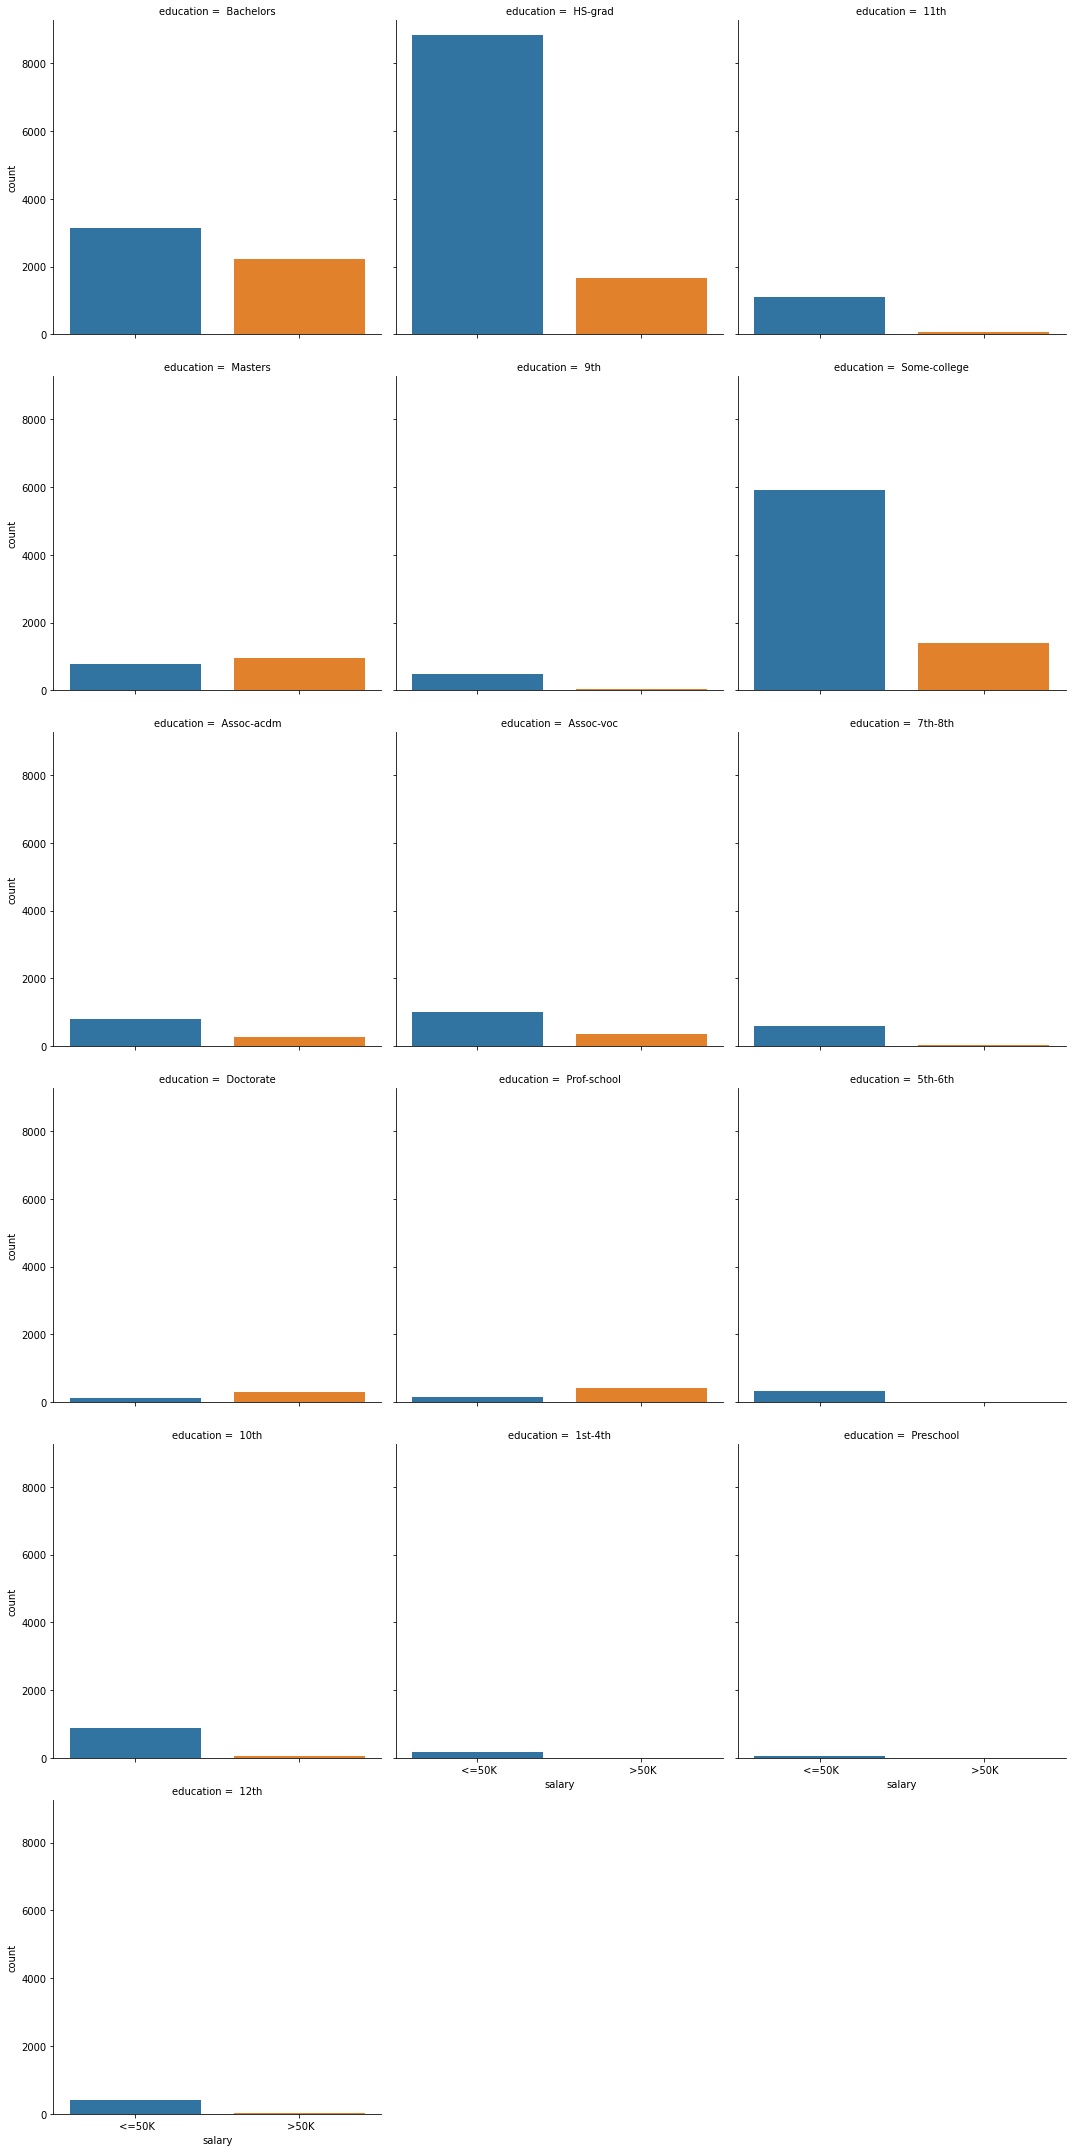

In [7]:
sns.catplot(x='salary', col='education', kind='count', data=df_salary, col_wrap=3)

In [8]:
df_salary['marital-status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

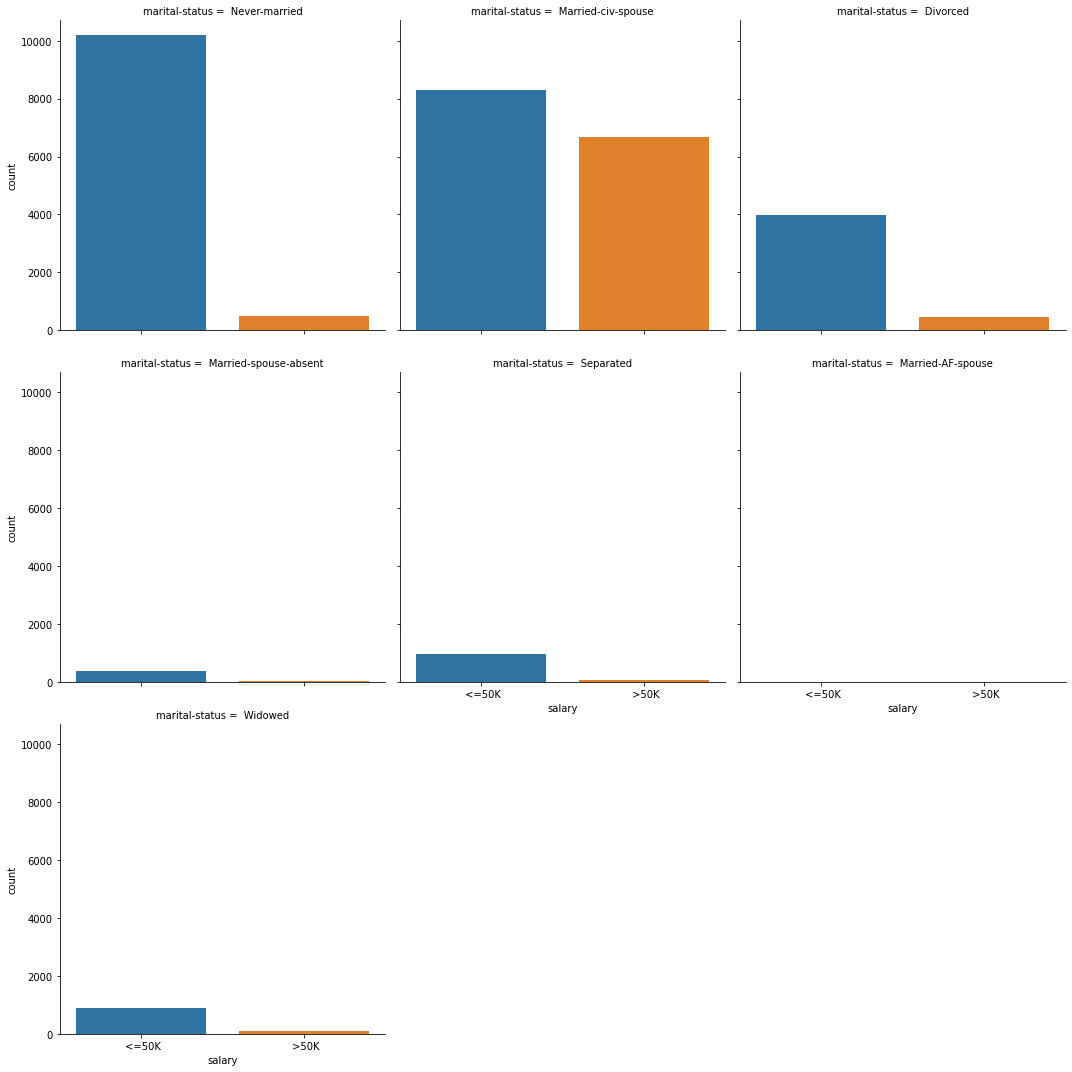

In [9]:
sns.catplot(x='salary', col='marital-status', kind='count', data=df_salary, col_wrap=3)

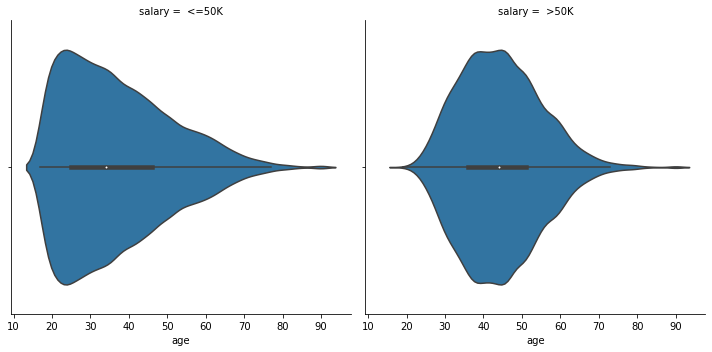

In [10]:
sns.catplot(x='age', col='salary', kind='violin', data=df_salary)

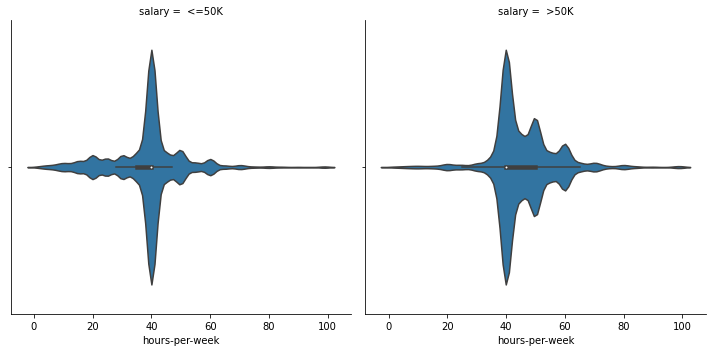

In [11]:
sns.catplot(x='hours-per-week', col='salary', kind='violin', data=df_salary)

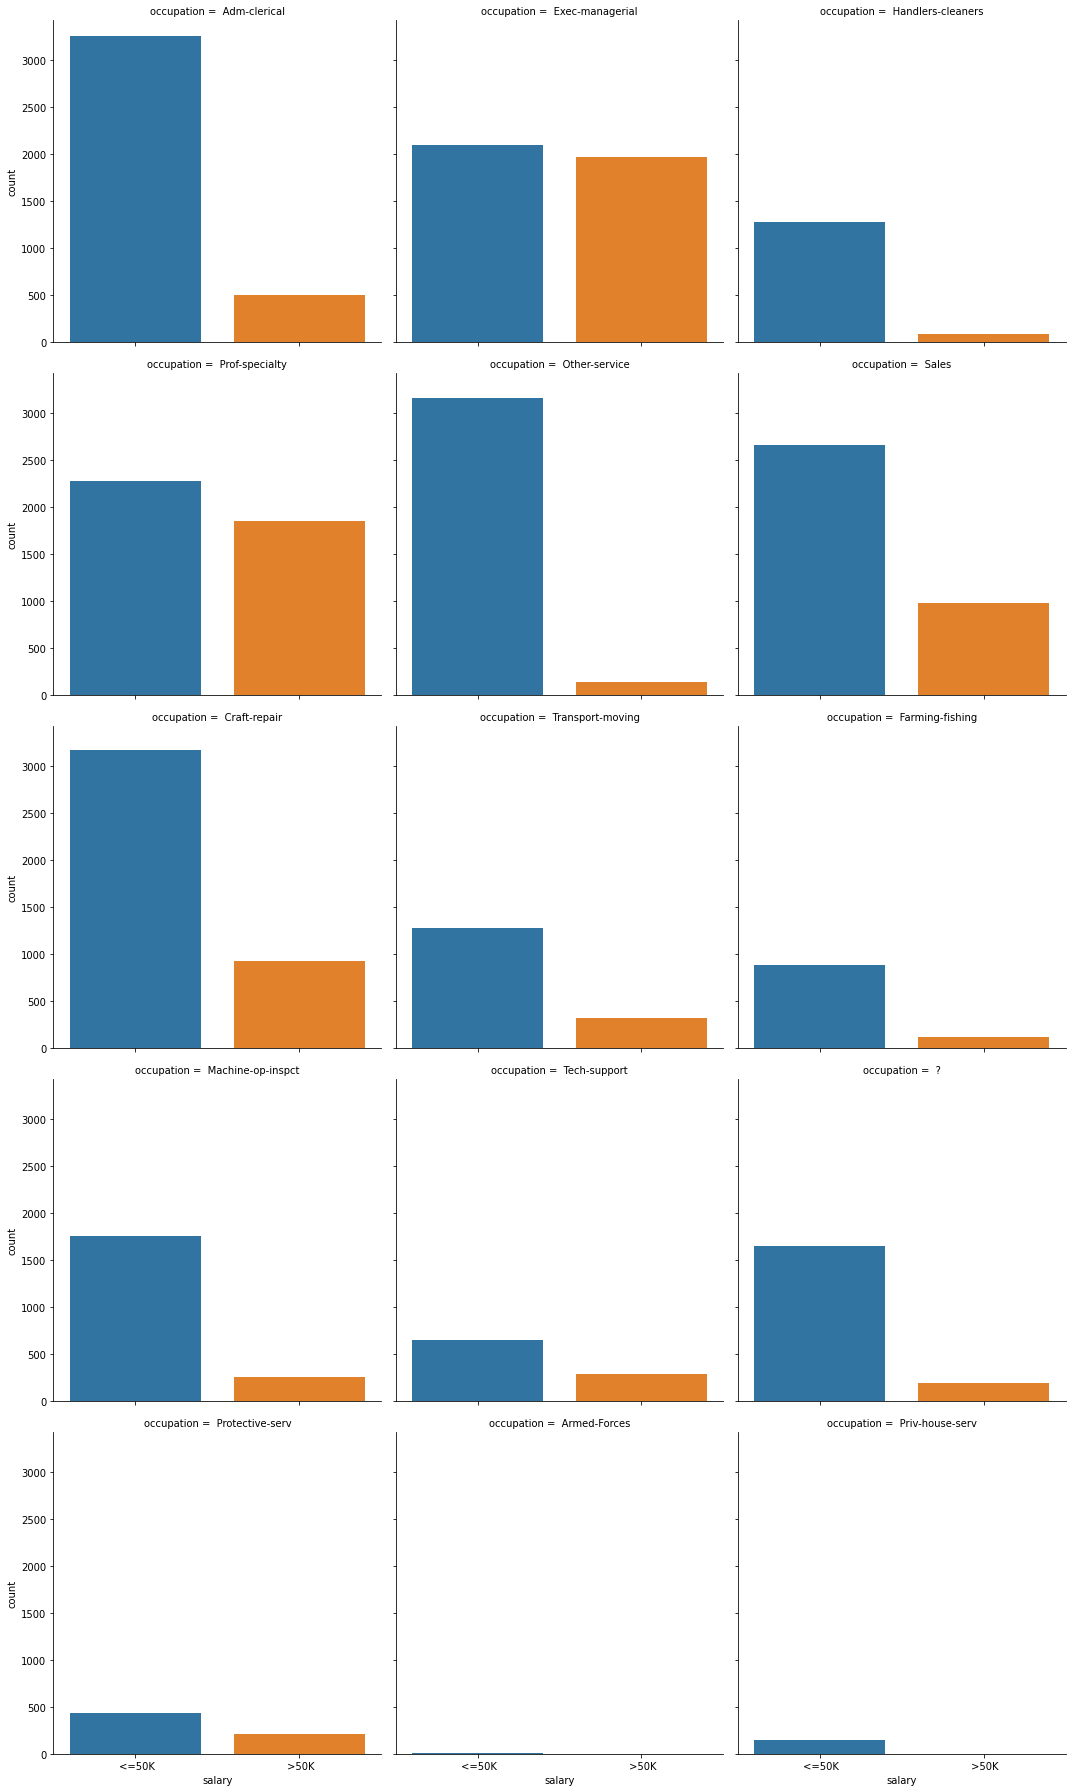

In [12]:
sns.catplot(x='salary', col='occupation', kind='count', data=df_salary, col_wrap=3)

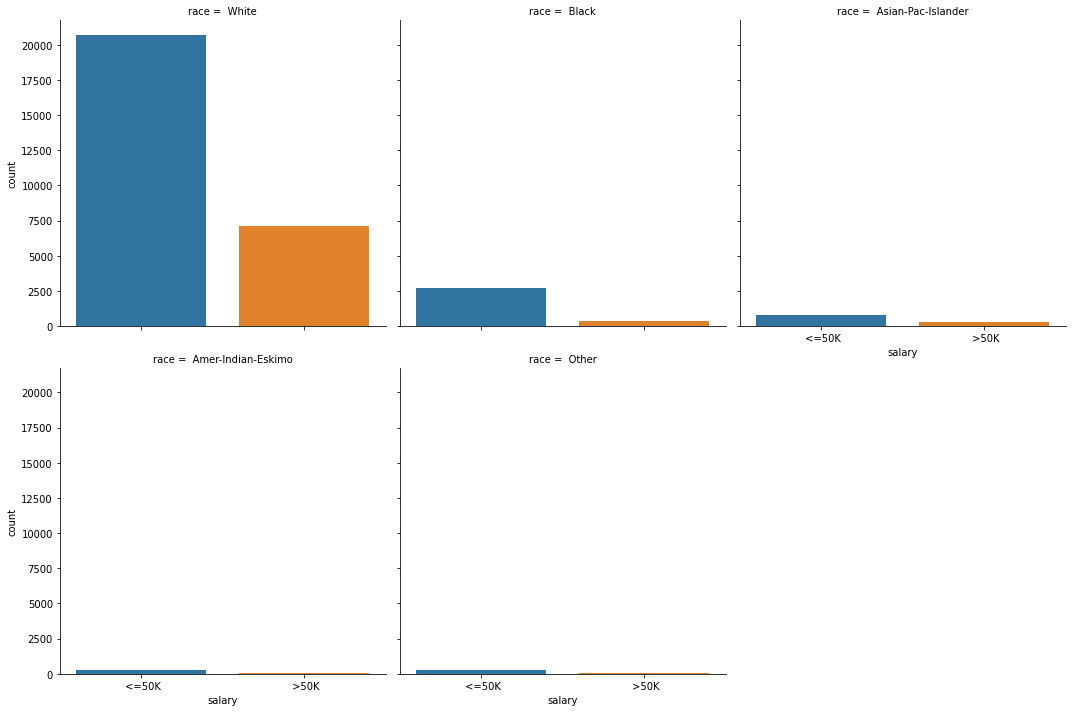

In [13]:
sns.catplot(x='salary', col='race', kind='count', data=df_salary, col_wrap=3)

While exploring the data we found some uselful features to be sex, age, education, marital status, hours per week, occupation. At first glance, it seems more likely that you make over 50K if you are an older, educated, married, full-time, male, or in a managerical or professional role. 
We also think it could be uselful to bin/group some of these columns like age, education, and marital status since some of the values in those columns are similar and don't appear as often. 

WRANGLE THE DATA: 
- Copy the original dataset
- Missing data & outliers
- Drop features that provide no useful information
- Feature engineering
- Standardize or normalize features

In [14]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [15]:
def wrangle_df(df):
    df = replace_Values(df)
    df = bin_columns(df)
    df = drop_columns(df)
    return df

def replace_Values(df):
    df.replace(' ?', np.nan, inplace = True)
    df['native-country'].replace(np.nan, 'Unknown', inplace=True)
    df['native-country'] = np.where(df['native-country'] != ' United-States', 'Immigrant', 'Native')
    df['marital-status'].replace([' Married-civ-spouse', ' Married-spouse-absent', ' Married-AF-spouse'], 'Married', inplace=True)
    df.dropna(inplace=True)
    return df

def dummy_variables(df):
    df = pd.get_dummies(df)
    return df   

def bin_columns(df):
    ageBins = np.linspace(min(df["age"]), max(df["age"]), 5)
    ageGroupNames = ['YoungAdult', 'MiddleAged', 'OlderAdult', 'RetirementAge']
    educationBins = [0, 8.5, 10.5, 13.5, 17]
    educationGroupNames = ['Low', 'HighSchoolGrad', 'CollegeGrad', 'ProfessionalSchool']
    hoursBins = [0, 39.5, 100]
    hoursGroupNames = ['Part-Time', 'Full-Time']
    

    df['AgeGroup'] = pd.cut(df['age'], ageBins, labels=ageGroupNames, include_lowest=True )
    df['EducationGroup'] = pd.cut(df['education-num'], educationBins, labels=educationGroupNames, include_lowest=True )
    df['HoursWorked'] = pd.cut(df['hours-per-week'], hoursBins, labels=hoursGroupNames, include_lowest=True )
    return df

def drop_columns(df):
    df.drop(columns=['age', 'capital-loss', 'capital-gain', 'hours-per-week',
                    'education','education-num', 'relationship','workclass',
                   'fnlwgt'], inplace=True)
    return df



In [16]:
df_salary = wrangle_df(df_salary)

Split the Data into train and test sets

In [17]:
y = df_salary.salary
df = df_salary.drop('salary', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15, random_state=17)

In [18]:
df_train = X_train
df_test = X_test
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26110 entries, 28489 to 11545
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   marital-status  26110 non-null  object  
 1   occupation      26110 non-null  object  
 2   race            26110 non-null  object  
 3   sex             26110 non-null  object  
 4   native-country  26110 non-null  object  
 5   AgeGroup        26110 non-null  category
 6   EducationGroup  26110 non-null  category
 7   HoursWorked     26110 non-null  category
dtypes: category(3), object(5)
memory usage: 1.3+ MB


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4608 entries, 18728 to 6435
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   marital-status  4608 non-null   object  
 1   occupation      4608 non-null   object  
 2   race            4608 non-null   object  
 3   sex             4608 non-null   object  
 4   native-country  4608 non-null   object  
 5   AgeGroup        4608 non-null   category
 6   EducationGroup  4608 non-null   category
 7   HoursWorked     4608 non-null   category
dtypes: category(3), object(5)
memory usage: 230.0+ KB


Convert to numerical data for the models

In [20]:
df_train = dummy_variables(df_train)
df_train.head(15)

,marital-status_ Divorced,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,marital-status_Married,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,...,AgeGroup_YoungAdult,AgeGroup_MiddleAged,AgeGroup_OlderAdult,AgeGroup_RetirementAge,EducationGroup_Low,EducationGroup_HighSchoolGrad,EducationGroup_CollegeGrad,EducationGroup_ProfessionalSchool,HoursWorked_Part-Time,HoursWorked_Full-Time
28489,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
1806,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4664,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
20313,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
29748,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
21379,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
11377,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
832,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
26299,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
15043,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [21]:
df_test = dummy_variables(df_test)
df_test.head()

,marital-status_ Divorced,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,marital-status_Married,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,...,AgeGroup_YoungAdult,AgeGroup_MiddleAged,AgeGroup_OlderAdult,AgeGroup_RetirementAge,EducationGroup_Low,EducationGroup_HighSchoolGrad,EducationGroup_CollegeGrad,EducationGroup_ProfessionalSchool,HoursWorked_Part-Time,HoursWorked_Full-Time
18728,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
295,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
11999,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
22610,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
14905,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0



IDENTIFY PROMISING MODELS
- Train multiple models from different categories (linear, naïve Bayes, SVM, Random Forest, etc) using standard parameters
- Measure and compare model performance
- Identify significant variables for each model
- Analyze model errors
- Revise feature selection and feature engineering
- Identify the top models

In [22]:
y_test = pd.get_dummies(y_test, drop_first=True)
y_train = pd.get_dummies(y_train, drop_first=True)

Naive Bayes

In [23]:
nb_classifier = MultinomialNB()
nb_classifier.fit(df_train, y_train)

pred = nb_classifier.predict(df_test)

score = metrics.accuracy_score(y_test, pred)
print(score)

0.8094618055555556


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

[[2954  493]
 [ 385  776]]


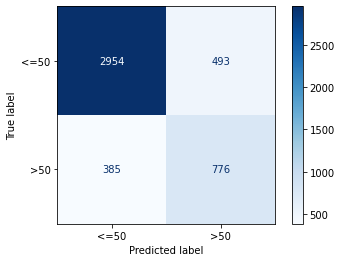

In [25]:
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['<=50', '>50'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Descision Tree

In [26]:
x = df_train.values
test = df_test.values
y = y_train.values

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(x,y)

DecisionTreeClassifier(max_depth=3)

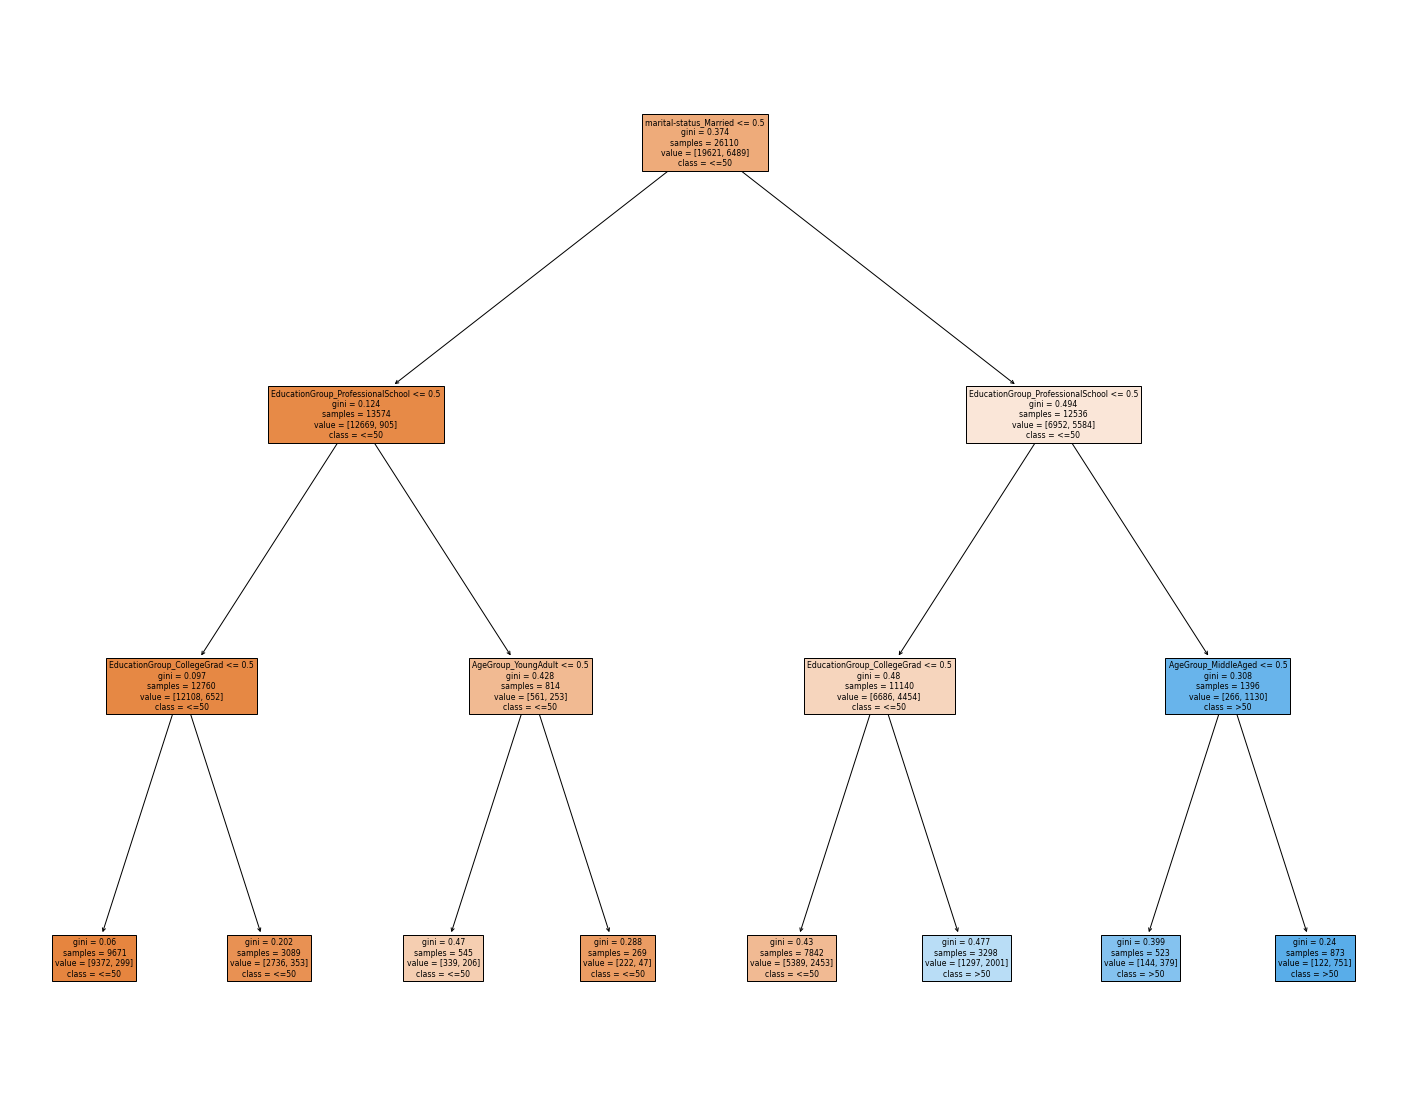

In [27]:
y_pred = clf.predict(test)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names=df_train.columns, class_names=['<=50', '>50'], filled=True)
fig.savefig("decistion_tree.png")

In [28]:
clf.score(df_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8075086805555556

Random Forest

In [29]:
x = df_train.values
test = df_test.values
y = y_train.values

model = RandomForestClassifier(n_estimators=300, max_depth=3)
model.fit(x, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=3, n_estimators=300)

In [30]:
y_pred = model.predict(df_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[3403   44]
 [1011  150]]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


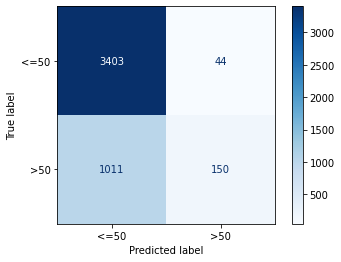

In [31]:
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['<=50', '>50'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
model.score(df_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7710503472222222

We explored using a couple different classification models. First we tried out the Naive Bayes, then the Decision Trees and the Random Forest. The Naive Bayes and the Decision Tree were equally as accurate, So we decided to move foward with the Random Forest model. The Random Forest model looks at multiple decision trees to get an average before classifying. For our data, we thought this would provide the most accurate classifications with some tuning. 

TUNE THE MODELS 
- Tune the hyperpatameters
- Consider combining the best models 
- Measure perofrmance of final model

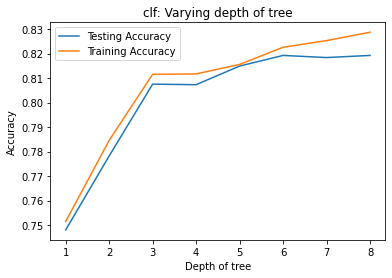

In [33]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(df_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(df_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(df_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == "":
/opt/conda/lib/python3.7

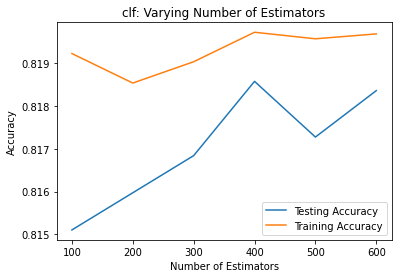

In [34]:
# Setup arrays to store train and test accuracies
dep = [100, 200, 300, 400, 500, 600]
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = RandomForestClassifier(n_estimators=k, max_depth=6, random_state=17)

    # Fit the classifier to the training data
    clf.fit(df_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(df_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(df_test, y_test)

# Generate plot
plt.title('clf: Varying Number of Estimators')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()

In [35]:
x = df_train.values
test = df_test.values
y = y_train.values

finalmodel = RandomForestClassifier(n_estimators=400, max_depth=6)
finalmodel.fit(x, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=6, n_estimators=400)

In [36]:
finalmodel.score(df_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8174913194444444

In [37]:
y_pred = finalmodel.predict(df_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[[3283  164]
 [ 677  484]]


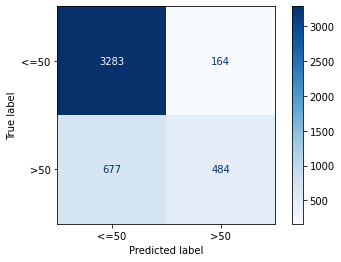

In [38]:
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['<=50', '>50'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

To tune the random forest model we looked at two attributes. One was the depth of the trees in the forest. Second was the number of trees in the forest. To determine the best value for both we looped through many different runs of the models, each with a different depth or number of trees, and then compared accuracy scores to see what value for each gives use the best model. After determining that a depth of 6 and a forest of 400 trees gives us the best model, we ended up with a random forest model with an accuracy of about 82%. 